# Decision Making with VIKOR Method
Cong Son DUONG, Mohammed Adel DJELLOUL ABBOU, Nikethan NIMALAKUMARAN, Samar HAMDI

Teacher: Mostafa AMELI

Université Gustave Eiffel, GRETTIA, UC Berkeley

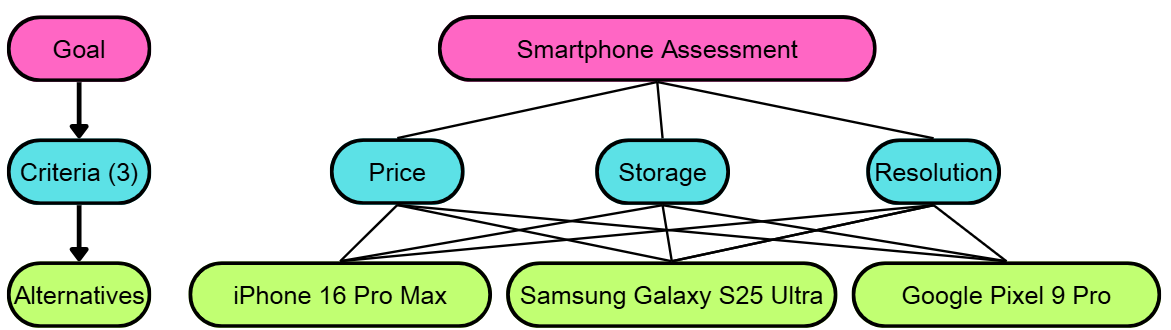

In [ ]:
# ! pip install pandas numpy

In [1]:
import pandas as pd
import numpy as np

## Step 0.1: Input Data

In [2]:
# Characteristics of Criteria table (criteria type and weights)
# Criteria have: Price (Min), Storage (Max), Resolution (Max)
criteria_data = {
    "name": ["Price", "Storage", "Resolution"],
    "type": ["Min", "Max", "Max"]
}
criteria_df = pd.DataFrame(criteria_data)

# Decision Matrix table (alternatives and their values for each criterion)
# Get data from https://www.gsmarena.com/compare.php3?idPhone1=13123&idPhone2=13322&idPhone3=13218
decision_data = {
    "Alternative": ["iPhone 16 Pro Max", "Samsung Galaxy S25 Ultra", "Google Pixel 9 Pro"],
    "Price": [1104.56, 1299.99, 689.97],
    "Storage": [256, 256, 128],
    "Resolution": [3607400, 4492800, 4492800]
}
decision_df = pd.DataFrame(decision_data)

In [3]:
print("Characteristics of Criteria Table:")
print(criteria_df)
print("\nDecision Matrix Table:")
print(decision_df)

Characteristics of Criteria Table:
         name type
0       Price  Min
1     Storage  Max
2  Resolution  Max

Decision Matrix Table:
                Alternative    Price  Storage  Resolution
0         iPhone 16 Pro Max  1104.56      256     3607400
1  Samsung Galaxy S25 Ultra  1299.99      256     4492800
2        Google Pixel 9 Pro   689.97      128     4492800


## Step 0.2: Determine weights using AHP

In [4]:
# Compute weights using the geometric mean method
def ahp_weights(pairwise):
    """
    Compute AHP weights from the pairwise comparison matrix using the geometric mean method.
    """
    n = pairwise.shape[0]
    gm = np.prod(pairwise, axis=1)**(1/n)  # Geometric mean of each row
    weights = gm / np.sum(gm)
    return weights

In [5]:
pairwise = np.array([
    [1,    2,   3],
    [1/2,  1,   1],
    [1/3,  1, 1]
])

weights_ahp = ahp_weights(pairwise)
criteria_df["weight_ahp"] = weights_ahp
criteria_df

,name,type,weight_ahp
0,Price,Min,0.549946
1,Storage,Max,0.240211
2,Resolution,Max,0.209844


## Step 1: Normalize the Decision Matrix

$f_{ij}(x) = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m} x_{ij}^2}}$


In [ ]:
# Normalize the decision matrix based on the formula
def normalize_decision_matrix(decision_df):
    sum_squares = np.sqrt((decision_df.drop(columns=["Alternative"]) ** 2).sum())
    df_norm = decision_df.copy()
    for crit, const in sum_squares.items():
        df_norm[crit] = decision_df[crit] / const
    return df_norm

In [ ]:
norm_decision_df = normalize_decision_matrix(decision_df)
print("Normalized Decision Matrix:")
norm_decision_df

Normalized Decision Matrix:


,Alternative,Price,Storage,Resolution
0,iPhone 16 Pro Max,0.600261,0.666667,0.493730
1,Samsung Galaxy S25 Ultra,0.706466,0.666667,0.614911
2,Google Pixel 9 Pro,0.374957,0.333333,0.614911


## Step 2: Determine Best (Ideal) and Worst (Anti-Ideal) Values
For each criterion:
- If it's a "benefit" (Max), the best value is the Maximum; the worst is the minimum.
- If it's a "cost" (Min), the best value is the minimum; the worst is the Maximum.

In [17]:
def compute_ideal_worst_values(norm_decision_df, criteria_df):
    ideal = {}
    worst = {}

    for _, row in criteria_df.iterrows():
        crit = row["name"]
        crit_type = row["type"]
        vals = norm_decision_df[crit]

        if crit_type.lower() == "max":  # Benefit criteria
            ideal[crit] = vals.max()
            worst[crit] = vals.min()
        else:  # Cost criteria (Min)
            ideal[crit] = vals.min()
            worst[crit] = vals.max()

    return ideal, worst
ideal, worst = compute_ideal_worst_values(norm_decision_df, criteria_df)
print("Ideal (Best) and Worst (Anti-Ideal) Values:")
print("Ideal:", ideal)
print("Worst:", worst)

Ideal (Best) and Worst (Anti-Ideal) Values:
Ideal: {'Price': 0.37495681777356665, 'Storage': 0.6666666666666666, 'Resolution': 0.6149108941698128}
Worst: {'Price': 0.7064656630541312, 'Storage': 0.3333333333333333, 'Resolution': 0.4937298699314865}


## Step 3: Compute Deviation $d_{ij}$ for Each Alternative
- For cost (Min):  $d_{ij} = (f_{ij} - f^{*}_j) / (f^{-}_j - f^{*}_j)$
- For benefit (Max): $d_{ij} = (f^{*}_j - f_{ij}) / (f^{*}_j - f^{-}_j)$

In [15]:
def compute_deviations(norm_df, criteria_df, ideal, worst):
    deviations = {}  
    for i, row in norm_df.iterrows():
        d_row = {}
        for _, crit_row in criteria_df.iterrows():
            crit = crit_row["name"]
            crit_type = crit_row["type"]
            val = row[crit]
            if ideal[crit] == worst[crit]:
                d = 0  # Avoid division by zero
            else:
                if crit_type.lower() == "Max":
                    d = (ideal[crit] - val) / (ideal[crit] - worst[crit])
                else:  # Min
                    d = (val - ideal[crit]) / (worst[crit] - ideal[crit])
            d_row[crit] = d
        deviations[row["Alternative"]] = d_row
    return deviations

In [16]:
deviations = compute_deviations(norm_decision_df, criteria_df, ideal, worst)
print("\nDeviation d_ij for Each Alternative:")
for alt, d in deviations.items():
    print(f"{alt}: {d}")


Deviation d_ij for Each Alternative:
iPhone 16 Pro Max: {'Price': 0.6796334546408314, 'Storage': 1.0, 'Resolution': 0.0}
Samsung Galaxy S25 Ultra: {'Price': 1.0, 'Storage': 1.0, 'Resolution': 1.0}
Google Pixel 9 Pro: {'Price': 0.0, 'Storage': 0.0, 'Resolution': 1.0}


## Step 4: Compute S and R Indices
- S (group utility): $sum_j (w_j * d_{ij})$
- R (individual regret): $Max_j (w_j * d_{ij})$

In [12]:
def compute_S_R(deviations, criteria_df):
    S_dict = {}
    R_dict = {}
    for alt, d_dict in deviations.items():
        weighted = []
        for _, crit_row in criteria_df.iterrows():
            crit = crit_row["name"]
            w = crit_row["weight_ahp"]
            weighted.append(w * d_dict[crit])
        S_dict[alt] = np.sum(weighted)
        R_dict[alt] = np.max(weighted)
    return S_dict, R_dict

In [13]:
S_dict, R_dict = compute_S_R(deviations, criteria_df)
print("S and R Indices:")
for alt in decision_df["Alternative"]:
    print(f"{alt}: S = {S_dict[alt]:.3f}, R = {R_dict[alt]:.3f}")

S and R Indices:
iPhone 16 Pro Max: S = 0.614, R = 0.374
Samsung Galaxy S25 Ultra: S = 1.000, R = 0.550
Google Pixel 9 Pro: S = 0.210, R = 0.210


## Step 5: Compute Q Index and Rank Alternatives

$Q_i = \gamma \frac{(S_i - S^*)}{(S^- - S^*)} + (1 - \gamma) \frac{(R_i - R^*)}{(R^- - R^*)}$

Where:
- $S^* = \min_{i} \{ S_i \}$;  $S^- = \max_{i} \{ S_i \}$
- $R^* = \min_{i} \{ R_i \}$;  $R^- = \max_{i} \{ R_i \}$

In [ ]:
def compute_q_index(S_dict, R_dict, decision_df, gamma=0.5):
    # Compute S* (Min of S), S^- (Max of S), R* (Min of R), R^- (Max of R)
    S_star, S_worst = min(S_dict.values()), max(S_dict.values())
    R_star, R_worst = min(R_dict.values()), max(R_dict.values())

    # Compute Q for each alternative using the VIKOR formula
    Q_dict = {}
    for alt in decision_df["Alternative"]:
        S_i, R_i = S_dict[alt], R_dict[alt]

        # Avoid division by zero
        S_diff = S_worst - S_star if S_worst != S_star else 1
        R_diff = R_worst - R_star if R_worst != R_star else 1

        # Compute Q index
        Q_dict[alt] = gamma * ((S_i - S_star) / S_diff) + (1 - gamma) * ((R_i - R_star) / R_diff)

    # Rank alternatives by Q index (lower is better)
    ranking = sorted(Q_dict.items(), key=lambda x: x[1])

    return Q_dict, ranking

# Call the function
Q_dict, ranking = compute_q_index(S_dict, R_dict, decision_df)

# Print ranking results
print("Ranking of Alternatives (Best to Worst):")
for rank, (alt, q_val) in enumerate(ranking, start=1):
    print(f"Rank {rank}: {alt} (Q = {q_val:.3f})")

Ranking of Alternatives (Best to Worst):
Rank 1: Google Pixel 9 Pro (Q = 0.000)
Rank 2: iPhone 16 Pro Max (Q = 0.497)
Rank 3: Samsung Galaxy S25 Ultra (Q = 1.000)
